importing packages

In [1]:
import numpy as np
import path as Path
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.cosmology import FlatwCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
from astropy.cosmology import wCDM
from astropy.cosmology import Flatw0waCDM
import scipy
from escape_functions_noastropy import *
from multiprocessing import Process
from multiprocessing import Queue
from multiprocessing import Pool
import emcee
import corner

# from multiprocessing import cpu_count
# ncpu = cpu_count()
# print("{0} CPUs".format(ncpu))

initializing cosmology

In [2]:
def cosmology(cosmology):
    case = cosmology.name
    if case == 'Flatw0waCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.wa, cosmology.h]
    
    elif case == 'FlatwCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.h]

    elif case == 'wCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.w0,cosmology.h]
        
    elif case == 'LambdaCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.h]

    elif case == 'FlatLambdaCDM':
        return [cosmology.Om0, cosmology.h]

# creating fake data: true values, then adding error
## y_err = 100

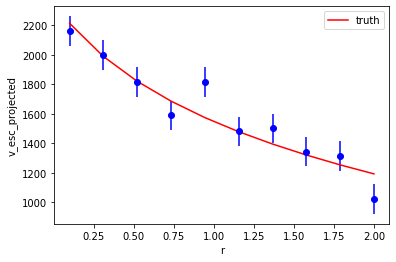

In [20]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.2, name = 'FlatLambdaCDM')
cosmo_params = cosmology(cosmo)

z = 0.2
radial_bins = 10
y_err = 100
N = 100

Omega_M = 0.2
little_h = 0.7

M200 = 5e14*u.solMass
M200,R200,conc,rho_s, sigma_rho_s,r_s, sigma_r_s =  nfws_errors(M200, 0.2, z,cosmo_params, cosmo.name)

radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = theta_data_array = radius_array / D_A(z, cosmo_params, cosmo.name).value


r, truth = v_esc_NFW_M200(theta_data_array,z,M200.value,N,cosmo_params, cosmo.name)
ydata = truth + np.random.normal(0,y_err,size=radial_bins) 
ydata_err = np.repeat(y_err, len(ydata))


plt.plot(r, truth, "r", label = 'truth')
plt.errorbar(r, ydata, yerr=ydata_err, fmt = "bo")
plt.ylabel("v_esc_projected")
plt.xlabel("r")
plt.legend()
plt.show()

fitting M200 to v_esc_NFW_M200

c:\Backups\GitHub\Cluster Cosmology\tutorials\sample code\escape_functions_noastropy.py:109: RuntimeWarning: invalid value encountered in double_scalars
  r200 =   (3*M200/(4*np.pi*200*rho_crit))**(1/3.0)
c:\Backups\GitHub\Cluster Cosmology\tutorials\sample code\escape_functions_noastropy.py:280: RuntimeWarning: invalid value encountered in double_scalars
  c200 = A * (mass/Mpivot)**B * (1+redshift)**C
C:\Users\nsuse\Anaconda3\envs\env_full\lib\site-packages\astropy\units\quantity.py:466: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
c:\Backups\GitHub\Cluster Cosmology\tutorials\sample code\escape_functions_noastropy.py:120: RuntimeWarning: invalid value encountered in sqrt
  v_esc = (-2.*phi_nfw(r,rho_s,r_s) +2*phi_nfw(req,rho_s,r_s)-q_z*(H_z**2.)*(r**2 - req**2) )**0.5


(50, 1000, 1)


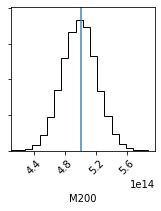

67
median(M200) =  498089231735713.75 +/- 21774155143919.375 21980726490594.0
median(logM200) =  14.697307152757658 +/- 0.018582079109345173 0.019601212938200163
Truth:  14.698970004336019


In [8]:
def lnprior(theta):
    p_M200 = theta[0]
    
    if not(1e13 < p_M200 < 1e17):
          return -np.inf
        
    return 0.0


def lnlike(theta, x, y, yerr): 
    p_M200 = theta[0]
    p_theta_array = x
    
    ymodel = v_esc_NFW_M200(p_theta_array, z, p_M200, N, cosmo_params, 'FlatLambdaCDM')

    inv_sigma2 = 1.0/(ydata_err**2)
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    
    return lp + ll

# lnprob([5e13], xdata, ydata, ydata_err)

ndim, nwalkers, nsteps = 1, 50, 1000
p0 = np.transpose([np.random.uniform(1,10000,size=nwalkers)*1e13])#print np.shape(p0)

# pool = Pool(processes=20)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err))
sampler.run_mcmc(p0, nsteps)

burn = 100
samples = sampler.chain[:, burn:, :].reshape((-1, 1))
print (np.shape(sampler.chain))

fig = corner.corner(samples[:,:], labels=["M200"], truths = [M200.value])
plt.show()

percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print (len(percentile_array))
M200_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
M200_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
M200_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
M200_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
print ('median(M200) = ', M200_fit_50, '+/-', M200_fit_67-M200_fit_50, M200_fit_50-M200_fit_33)
print ('median(logM200) = ', np.log10(M200_fit_50), '+/-', np.log10(M200_fit_67)-np.log10(M200_fit_50), np.log10(M200_fit_50) -np.log10(M200_fit_33))
sigma_M200_fit = (M200_fit_67-M200_fit_50 + M200_fit_50-M200_fit_33)/2.0
print ('Truth: ', np.log10(M200.value))

fit rho_s, r_s to v_esc_NFWs (hold M200 constant)

In [14]:
def lnprior(theta):
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    
    if not((1e13 < p_rho_s < 1e17) & (0.2 < p_r_s < 1) & (p_M200 == 5e14)):
          return -np.inf
        
    return 0.0

def lnlike(theta, x, y, yerr): 
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    p_theta_array = x
    
    ymodel = v_esc_NFWs(p_theta_array,z,M200, p_rho_s, p_r_s,N,cosmo_params,'FlatLambdaCDM')

    inv_sigma2 = 1.0/(ydata_err**2)
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    
    return lp + ll

ndim, nwalkers, nsteps = 3, 100, 2000
p0 = np.transpose([np.random.uniform(1,10000,size=nwalkers)*1e13, np.random.uniform(0.2,1,size=nwalkers),np.random.uniform(1,1,size=nwalkers)*M200.value])#print np.shape(p0)

# pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err))
sampler.run_mcmc(p0, nsteps)

burn = 500
samples = sampler.chain[:, burn:, :].reshape((-1, 3))
print (np.shape(sampler.chain))

fig = corner.corner(samples[:,:], labels=["rho_s", "r_s", "M200"], truths = [rho_s, r_s, M200.value], range=[(1e14,1e15), (0.0,1.0), (1e13,1e15)])
plt.show()

percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print (len(percentile_array))
rho_s_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
rho_s_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
rho_s_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
rho_s_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
r_s_fit =  np.percentile(sampler.chain[:,burn:,1],percentile_array)
r_s_fit_50 =  np.percentile(sampler.chain[:,burn:,1],50)
r_s_fit_33 =  np.percentile(sampler.chain[:,burn:,1],33-16.5)
r_s_fit_67 =  np.percentile(sampler.chain[:,burn:,1],67+16.5)
print ('median(rho_s) = ', rho_s_fit_50, '+/-', rho_s_fit_67-rho_s_fit_50, rho_s_fit_50-rho_s_fit_33)
print ('median(log rho_s) = ', np.log10(rho_s_fit_50), '+/-', np.log10(rho_s_fit_67)-np.log10(rho_s_fit_50), np.log10(rho_s_fit_50) -np.log10(rho_s_fit_33))
sigma_rho_s_fit = (rho_s_fit_67-rho_s_fit_50 + rho_s_fit_50-rho_s_fit_33)/2.0
print ('Truth: ', np.log10(rho_s))
print ('median(r_s) = ', r_s_fit_50, '+/-', r_s_fit_67-r_s_fit_50, r_s_fit_50-r_s_fit_33)
sigma_rho_s_fit = (r_s_fit_67-r_s_fit_50 + r_s_fit_50-r_s_fit_33)/2.0
print ('Truth: ',r_s)

ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance

fit rho_s, r_s, M200 to v_esc_NFWs 

(100, 2000, 3)


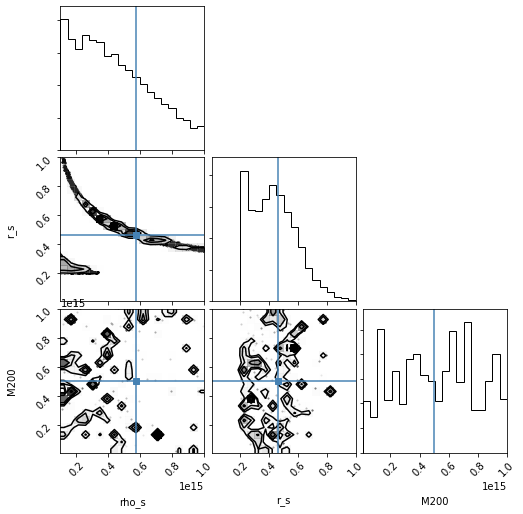

67
median(rho_s) =  261983093114339.56 +/- 421426730925816.8 228516677860083.97
median(log rho_s) =  14.418273265350024 +/- 0.41640795215598025 0.8936640698333829
Truth:  14.759302927824459
median(r_s) =  0.4244138611085525 +/- 0.16643890882241397 0.1608442733494717
Truth:  0.46071067596929743
median(M200) =  261983093114339.56 +/- 421426730925816.8 228516677860083.97
median(logM200) =  14.418273265350024 +/- 0.41640795215598025 0.8936640698333829
Truth:  14.698970004336019


In [21]:
def lnprior(theta):
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    
    if not((1e13 < p_rho_s < 1e17) & (0.2 < p_r_s < 1) & (1e13 < p_M200 < 1e17)):
          return -np.inf
        
    return 0.0

def lnlike(theta, x, y, yerr): 
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    p_theta_array = x
    
    ymodel = v_esc_NFWs(p_theta_array,z,M200, p_rho_s, p_r_s,N,cosmo_params,'FlatLambdaCDM')

    inv_sigma2 = 1.0/(ydata_err**2)
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    
    return lp + ll

ndim, nwalkers, nsteps = 3, 100, 2000
p0 = np.transpose([np.random.uniform(1,10000,size=nwalkers)*1e13, np.random.uniform(0.2,1,size=nwalkers),np.random.uniform(1,10000,size=nwalkers)*1e13])#print np.shape(p0)

# pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err))
sampler.run_mcmc(p0, nsteps)

burn = 500
samples = sampler.chain[:, burn:, :].reshape((-1, 3))
print (np.shape(sampler.chain))

fig = corner.corner(samples[:,:], labels=["rho_s", "r_s", "M200"], truths = [rho_s, r_s, M200.value], range=[(1e14,1e15), (0.0,1.0), (1e13,1e15)])
plt.show()

percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print (len(percentile_array))
rho_s_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
rho_s_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
rho_s_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
rho_s_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
r_s_fit =  np.percentile(sampler.chain[:,burn:,1],percentile_array)
r_s_fit_50 =  np.percentile(sampler.chain[:,burn:,1],50)
r_s_fit_33 =  np.percentile(sampler.chain[:,burn:,1],33-16.5)
r_s_fit_67 =  np.percentile(sampler.chain[:,burn:,1],67+16.5)
print ('median(rho_s) = ', rho_s_fit_50, '+/-', rho_s_fit_67-rho_s_fit_50, rho_s_fit_50-rho_s_fit_33)
print ('median(log rho_s) = ', np.log10(rho_s_fit_50), '+/-', np.log10(rho_s_fit_67)-np.log10(rho_s_fit_50), np.log10(rho_s_fit_50) -np.log10(rho_s_fit_33))
sigma_rho_s_fit = (rho_s_fit_67-rho_s_fit_50 + rho_s_fit_50-rho_s_fit_33)/2.0
print ('Truth: ', np.log10(rho_s))
print ('median(r_s) = ', r_s_fit_50, '+/-', r_s_fit_67-r_s_fit_50, r_s_fit_50-r_s_fit_33)
sigma_rho_s_fit = (r_s_fit_67-r_s_fit_50 + r_s_fit_50-r_s_fit_33)/2.0
print ('Truth: ',r_s)
M200_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
M200_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
M200_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
M200_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
print ('median(M200) = ', M200_fit_50, '+/-', M200_fit_67-M200_fit_50, M200_fit_50-M200_fit_33)
print ('median(logM200) = ', np.log10(M200_fit_50), '+/-', np.log10(M200_fit_67)-np.log10(M200_fit_50), np.log10(M200_fit_50) -np.log10(M200_fit_33))
sigma_M200_fit = (M200_fit_67-M200_fit_50 + M200_fit_50-M200_fit_33)/2.0
print ('Truth: ', np.log10(M200.value))

In [57]:
def rel_err(x, truth):
    return (np.abs(truth - x) / truth)

print(rel_err(14.418273265350024, 14.759302927824459)) # log rho_s
print(rel_err(0.4244138611085525, 0.46071067596929743)) # r_s
print(rel_err(14.418273265350024, 14.698970004336019)) # r_s


0.023106081916072125
0.0787844014779545
0.0190963542957903


## y_err = 1

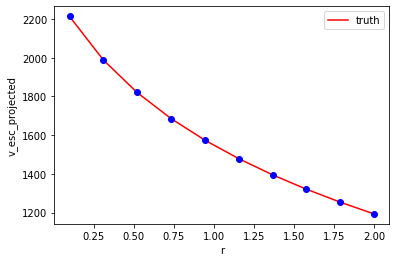

In [22]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.2, name = 'FlatLambdaCDM')
cosmo_params = cosmology(cosmo)

z = 0.2
radial_bins = 10
y_err = 1
N = 100

Omega_M = 0.2
little_h = 0.7

M200 = 5e14*u.solMass
M200,R200,conc,rho_s, sigma_rho_s,r_s, sigma_r_s =  nfws_errors(M200, 0.2, z,cosmo_params, cosmo.name)

radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = theta_data_array = radius_array / D_A(z, cosmo_params, cosmo.name).value


r, truth = v_esc_NFW_M200(theta_data_array,z,M200.value,N,cosmo_params, cosmo.name)
ydata = truth + np.random.normal(0,y_err,size=radial_bins) 
ydata_err = np.repeat(y_err, len(ydata))


plt.plot(r, truth, "r", label = 'truth')
plt.errorbar(r, ydata, yerr=ydata_err, fmt = "bo")
plt.ylabel("v_esc_projected")
plt.xlabel("r")
plt.legend()
plt.show()

(100, 2000, 3)


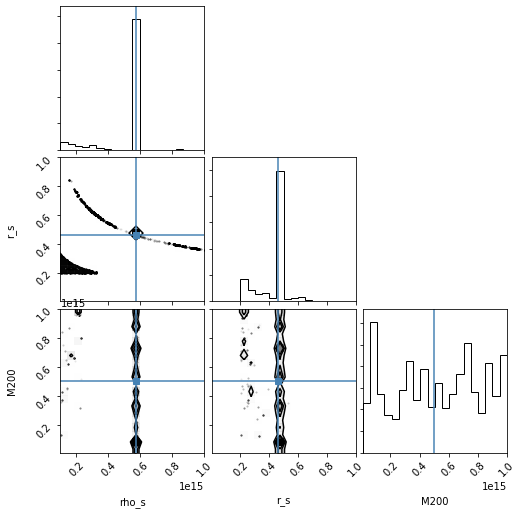

67
median(rho_s) =  572129898340480.1 +/- 4685663852650.875 487983375356917.0
median(log rho_s) =  14.757494643701705 +/- 0.0035423252139512584 0.8324584684908718
Truth:  14.759302927824459
median(r_s) =  0.4603363022834937 +/- 0.0018001147984185173 0.16812351541395087
Truth:  0.46071067596929743
median(M200) =  572129898340480.1 +/- 4685663852650.875 487983375356917.0
median(logM200) =  14.757494643701705 +/- 0.0035423252139512584 0.8324584684908718
Truth:  14.698970004336019


In [23]:
def lnprior(theta):
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    
    if not((1e13 < p_rho_s < 1e17) & (0.2 < p_r_s < 1) & (1e13 < p_M200 < 1e17)):
          return -np.inf
        
    return 0.0

def lnlike(theta, x, y, yerr): 
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    p_theta_array = x
    
    ymodel = v_esc_NFWs(p_theta_array,z,M200, p_rho_s, p_r_s,N,cosmo_params,'FlatLambdaCDM')

    inv_sigma2 = 1.0/(ydata_err**2)
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    
    return lp + ll

ndim, nwalkers, nsteps = 3, 100, 2000
p0 = np.transpose([np.random.uniform(1,10000,size=nwalkers)*1e13, np.random.uniform(0.2,1,size=nwalkers),np.random.uniform(1,10000,size=nwalkers)*1e13])#print np.shape(p0)

# pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err))
sampler.run_mcmc(p0, nsteps)

burn = 500
samples = sampler.chain[:, burn:, :].reshape((-1, 3))
print (np.shape(sampler.chain))

fig = corner.corner(samples[:,:], labels=["rho_s", "r_s", "M200"], truths = [rho_s, r_s, M200.value], range=[(1e14,1e15), (0.0,1.0), (1e13,1e15)])
plt.show()

percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print (len(percentile_array))
rho_s_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
rho_s_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
rho_s_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
rho_s_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
r_s_fit =  np.percentile(sampler.chain[:,burn:,1],percentile_array)
r_s_fit_50 =  np.percentile(sampler.chain[:,burn:,1],50)
r_s_fit_33 =  np.percentile(sampler.chain[:,burn:,1],33-16.5)
r_s_fit_67 =  np.percentile(sampler.chain[:,burn:,1],67+16.5)
print ('median(rho_s) = ', rho_s_fit_50, '+/-', rho_s_fit_67-rho_s_fit_50, rho_s_fit_50-rho_s_fit_33)
print ('median(log rho_s) = ', np.log10(rho_s_fit_50), '+/-', np.log10(rho_s_fit_67)-np.log10(rho_s_fit_50), np.log10(rho_s_fit_50) -np.log10(rho_s_fit_33))
sigma_rho_s_fit = (rho_s_fit_67-rho_s_fit_50 + rho_s_fit_50-rho_s_fit_33)/2.0
print ('Truth: ', np.log10(rho_s))
print ('median(r_s) = ', r_s_fit_50, '+/-', r_s_fit_67-r_s_fit_50, r_s_fit_50-r_s_fit_33)
sigma_rho_s_fit = (r_s_fit_67-r_s_fit_50 + r_s_fit_50-r_s_fit_33)/2.0
print ('Truth: ',r_s)
M200_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
M200_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
M200_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
M200_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
print ('median(M200) = ', M200_fit_50, '+/-', M200_fit_67-M200_fit_50, M200_fit_50-M200_fit_33)
print ('median(logM200) = ', np.log10(M200_fit_50), '+/-', np.log10(M200_fit_67)-np.log10(M200_fit_50), np.log10(M200_fit_50) -np.log10(M200_fit_33))
sigma_M200_fit = (M200_fit_67-M200_fit_50 + M200_fit_50-M200_fit_33)/2.0
print ('Truth: ', np.log10(M200.value))

In [58]:
print(rel_err(14.757494643701705, 14.759302927824459)) # log rho_s
print(rel_err(0.4603363022834937, 0.46071067596929743)) # r_s
print(rel_err(14.757494643701705, 14.698970004336019)) # r_s

0.00012251826062498116
0.0008126004135156604
0.003981546962026721


## y_err = 1000

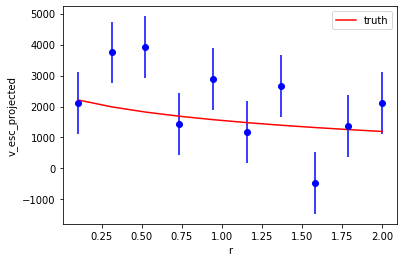

In [32]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.2, name = 'FlatLambdaCDM')
cosmo_params = cosmology(cosmo)

z = 0.2
radial_bins = 10
y_err = 1000
N = 100

Omega_M = 0.2
little_h = 0.7

M200 = 5e14*u.solMass
M200,R200,conc,rho_s, sigma_rho_s,r_s, sigma_r_s =  nfws_errors(M200, 0.2, z,cosmo_params, cosmo.name)

radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = theta_data_array = radius_array / D_A(z, cosmo_params, cosmo.name).value


r, truth = v_esc_NFW_M200(theta_data_array,z,M200.value,N,cosmo_params, cosmo.name)
ydata = truth + np.random.normal(0,y_err,size=radial_bins) 
ydata_err = np.repeat(y_err, len(ydata))


plt.plot(r, truth, "r", label = 'truth')
plt.errorbar(r, ydata, yerr=ydata_err, fmt = "bo")
plt.ylabel("v_esc_projected")
plt.xlabel("r")
plt.legend()
plt.show()

(100, 2000, 3)


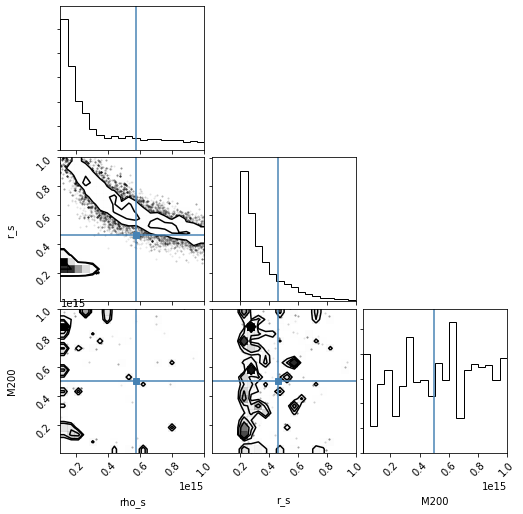

67
median(rho_s) =  211896600211134.28 +/- 3341492322400249.0 178167659448779.84
median(log rho_s) =  14.326123988700465 +/- 1.2245187554339925 0.7981212860611517
Truth:  14.759302927824459
median(r_s) =  0.29703137166402815 +/- 0.19503176913672582 0.0725252262429448
Truth:  0.46071067596929743
median(M200) =  211896600211134.28 +/- 3341492322400249.0 178167659448779.84
median(logM200) =  14.326123988700465 +/- 1.2245187554339925 0.7981212860611517
Truth:  14.698970004336019


In [33]:
def lnprior(theta):
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    
    if not((1e13 < p_rho_s < 1e17) & (0.2 < p_r_s < 1) & (1e13 < p_M200 < 1e17)):
          return -np.inf
        
    return 0.0

def lnlike(theta, x, y, yerr): 
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    p_theta_array = x
    
    ymodel = v_esc_NFWs(p_theta_array,z,M200, p_rho_s, p_r_s,N,cosmo_params,'FlatLambdaCDM')

    inv_sigma2 = 1.0/(ydata_err**2)
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    
    return lp + ll

ndim, nwalkers, nsteps = 3, 100, 2000
p0 = np.transpose([np.random.uniform(1,10000,size=nwalkers)*1e13, np.random.uniform(0.2,1,size=nwalkers),np.random.uniform(1,10000,size=nwalkers)*1e13])#print np.shape(p0)

# pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err))
sampler.run_mcmc(p0, nsteps)

burn = 500
samples = sampler.chain[:, burn:, :].reshape((-1, 3))
print (np.shape(sampler.chain))

fig = corner.corner(samples[:,:], labels=["rho_s", "r_s", "M200"], truths = [rho_s, r_s, M200.value], range=[(1e14,1e15), (0.0,1.0), (1e13,1e15)])
plt.show()

percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print (len(percentile_array))
rho_s_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
rho_s_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
rho_s_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
rho_s_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
r_s_fit =  np.percentile(sampler.chain[:,burn:,1],percentile_array)
r_s_fit_50 =  np.percentile(sampler.chain[:,burn:,1],50)
r_s_fit_33 =  np.percentile(sampler.chain[:,burn:,1],33-16.5)
r_s_fit_67 =  np.percentile(sampler.chain[:,burn:,1],67+16.5)
print ('median(rho_s) = ', rho_s_fit_50, '+/-', rho_s_fit_67-rho_s_fit_50, rho_s_fit_50-rho_s_fit_33)
print ('median(log rho_s) = ', np.log10(rho_s_fit_50), '+/-', np.log10(rho_s_fit_67)-np.log10(rho_s_fit_50), np.log10(rho_s_fit_50) -np.log10(rho_s_fit_33))
sigma_rho_s_fit = (rho_s_fit_67-rho_s_fit_50 + rho_s_fit_50-rho_s_fit_33)/2.0
print ('Truth: ', np.log10(rho_s))
print ('median(r_s) = ', r_s_fit_50, '+/-', r_s_fit_67-r_s_fit_50, r_s_fit_50-r_s_fit_33)
sigma_rho_s_fit = (r_s_fit_67-r_s_fit_50 + r_s_fit_50-r_s_fit_33)/2.0
print ('Truth: ',r_s)
M200_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
M200_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
M200_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
M200_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
print ('median(M200) = ', M200_fit_50, '+/-', M200_fit_67-M200_fit_50, M200_fit_50-M200_fit_33)
print ('median(logM200) = ', np.log10(M200_fit_50), '+/-', np.log10(M200_fit_67)-np.log10(M200_fit_50), np.log10(M200_fit_50) -np.log10(M200_fit_33))
sigma_M200_fit = (M200_fit_67-M200_fit_50 + M200_fit_50-M200_fit_33)/2.0
print ('Truth: ', np.log10(M200.value))

In [59]:
print(rel_err(14.326123988700465, 14.759302927824459)) # log rho_s
print(rel_err(0.29703137166402815, 0.46071067596929743)) # r_s
print(rel_err(14.326123988700465, 14.698970004336019)) # r_s

0.029349552701934113
0.35527569219207145
0.025365451832718152


# testing v_esc_NFWs fit at different levels of mass
## M200 = 1e13

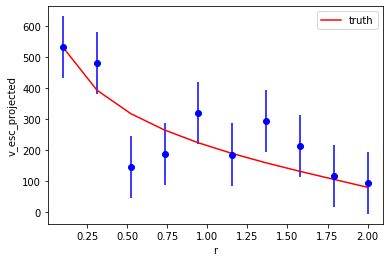

In [60]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.2, name = 'FlatLambdaCDM')
cosmo_params = cosmology(cosmo)

z = 0.2
radial_bins = 10
y_err = 100
N = 100

Omega_M = 0.2
little_h = 0.7

M200 = 1e13*u.solMass
M200,R200,conc,rho_s, sigma_rho_s,r_s, sigma_r_s =  nfws_errors(M200, 0.2, z,cosmo_params, cosmo.name)

radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = theta_data_array = radius_array / D_A(z, cosmo_params, cosmo.name).value


r, truth = v_esc_NFW_M200(theta_data_array,z,M200.value,N,cosmo_params, cosmo.name)
ydata = truth + np.random.normal(0,y_err,size=radial_bins) 
ydata_err = np.repeat(y_err, len(ydata))


plt.plot(r, truth, "r", label = 'truth')
plt.errorbar(r, ydata, yerr=ydata_err, fmt = "bo")
plt.ylabel("v_esc_projected")
plt.xlabel("r")
plt.legend()
plt.show()

(100, 2000, 3)


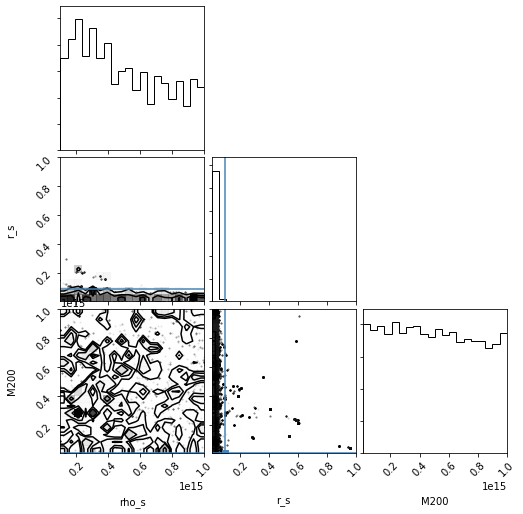

67
median(rho_s) =  3.424716455181364e+16 +/- 4.076211498182756e+16 2.880444469165758e+16
median(log rho_s) =  16.534624620486063 +/- 0.34049037358513345 0.798808638974311
Truth:  15.074562738099713
median(r_s) =  0.008863903983751599 +/- 0.01015476201472538 0.005973830992029365
Truth:  0.09003087293385749
median(M200) =  3.424716455181364e+16 +/- 4.076211498182756e+16 2.880444469165758e+16
median(logM200) =  16.534624620486063 +/- 0.34049037358513345 0.798808638974311
Truth:  13.0


In [61]:
def lnprior(theta):
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    
    if not((1e13 < p_rho_s < 1e17) & (0.0 < p_r_s < 1) & (1e11 < p_M200 < 1e15)):
          return -np.inf
        
    return 0.0

def lnlike(theta, x, y, yerr): 
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    p_theta_array = x
    
    ymodel = v_esc_NFWs(p_theta_array,z,M200, p_rho_s, p_r_s,N,cosmo_params,'FlatLambdaCDM')

    inv_sigma2 = 1.0/(ydata_err**2)
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    
    return lp + ll

ndim, nwalkers, nsteps = 3, 100, 2000
p0 = np.transpose([np.random.uniform(1,10000,size=nwalkers)*1e13, np.random.uniform(0.2,1,size=nwalkers),np.random.uniform(1,10000,size=nwalkers)*1e11])#print np.shape(p0)

# pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err))
sampler.run_mcmc(p0, nsteps)

burn = 500
samples = sampler.chain[:, burn:, :].reshape((-1, 3))
print (np.shape(sampler.chain))

fig = corner.corner(samples[:,:], labels=["rho_s", "r_s", "M200"], truths = [rho_s, r_s, M200.value], range=[(1e14,1e15), (0.0,1.0), (1e13,1e15)])
plt.show()

percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print (len(percentile_array))
rho_s_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
rho_s_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
rho_s_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
rho_s_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
r_s_fit =  np.percentile(sampler.chain[:,burn:,1],percentile_array)
r_s_fit_50 =  np.percentile(sampler.chain[:,burn:,1],50)
r_s_fit_33 =  np.percentile(sampler.chain[:,burn:,1],33-16.5)
r_s_fit_67 =  np.percentile(sampler.chain[:,burn:,1],67+16.5)
print ('median(rho_s) = ', rho_s_fit_50, '+/-', rho_s_fit_67-rho_s_fit_50, rho_s_fit_50-rho_s_fit_33)
print ('median(log rho_s) = ', np.log10(rho_s_fit_50), '+/-', np.log10(rho_s_fit_67)-np.log10(rho_s_fit_50), np.log10(rho_s_fit_50) -np.log10(rho_s_fit_33))
sigma_rho_s_fit = (rho_s_fit_67-rho_s_fit_50 + rho_s_fit_50-rho_s_fit_33)/2.0
print ('Truth: ', np.log10(rho_s))
print ('median(r_s) = ', r_s_fit_50, '+/-', r_s_fit_67-r_s_fit_50, r_s_fit_50-r_s_fit_33)
sigma_rho_s_fit = (r_s_fit_67-r_s_fit_50 + r_s_fit_50-r_s_fit_33)/2.0
print ('Truth: ',r_s)
M200_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
M200_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
M200_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
M200_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
print ('median(M200) = ', M200_fit_50, '+/-', M200_fit_67-M200_fit_50, M200_fit_50-M200_fit_33)
print ('median(logM200) = ', np.log10(M200_fit_50), '+/-', np.log10(M200_fit_67)-np.log10(M200_fit_50), np.log10(M200_fit_50) -np.log10(M200_fit_33))
sigma_M200_fit = (M200_fit_67-M200_fit_50 + M200_fit_50-M200_fit_33)/2.0
print ('Truth: ', np.log10(M200.value))

In [63]:
print(rel_err(16.534624620486063, 15.074562738099713))
print(rel_err(0.008863903983751599, 0.09003087293385749))
print(rel_err(16.534624620486063, 13.0))

0.09685600224384382
0.9015459509066007
0.27189420157585104


## m200 = 1e16

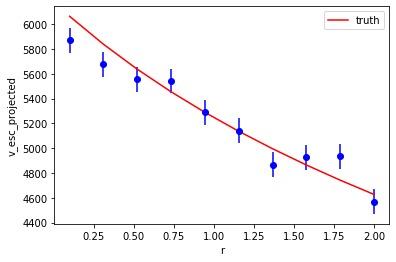

In [54]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.2, name = 'FlatLambdaCDM')
cosmo_params = cosmology(cosmo)

z = 0.2
radial_bins = 10
y_err = 100
N = 100

Omega_M = 0.2
little_h = 0.7

M200 = 1e16*u.solMass
M200,R200,conc,rho_s, sigma_rho_s,r_s, sigma_r_s =  nfws_errors(M200, 0.2, z,cosmo_params, cosmo.name)

radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = theta_data_array = radius_array / D_A(z, cosmo_params, cosmo.name).value


r, truth = v_esc_NFW_M200(theta_data_array,z,M200.value,N,cosmo_params, cosmo.name)
ydata = truth + np.random.normal(0,y_err,size=radial_bins) 
ydata_err = np.repeat(y_err, len(ydata))


plt.plot(r, truth, "r", label = 'truth')
plt.errorbar(r, ydata, yerr=ydata_err, fmt = "bo")
plt.ylabel("v_esc_projected")
plt.xlabel("r")
plt.legend()
plt.show()

(100, 2000, 3)


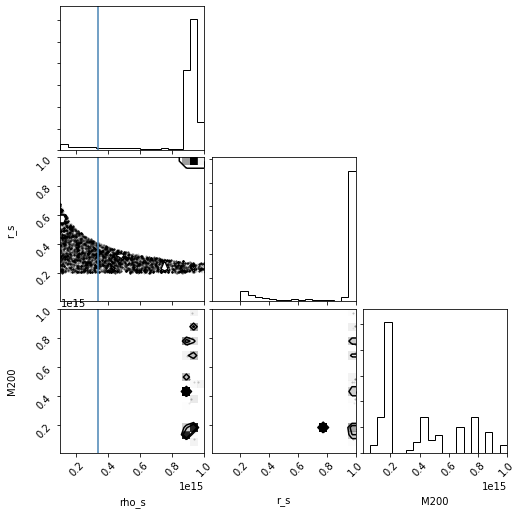

67
median(rho_s) =  913339499164658.5 +/- 37147891159317.875 426551739389018.6
median(log rho_s) =  14.960632239973881 +/- 0.017314119682035667 0.2732925905652568
Truth:  14.52814867806418
median(r_s) =  0.9838098412642416 +/- 0.012310370634659007 0.49507349430307834
Truth:  1.6083903584942014
median(M200) =  913339499164658.5 +/- 37147891159317.875 426551739389018.6
median(logM200) =  14.960632239973881 +/- 0.017314119682035667 0.2732925905652568
Truth:  16.0


In [55]:
def lnprior(theta):
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    
    if not((1e13 < p_rho_s < 1e17) & (0.2 < p_r_s < 1) & (1e14 < p_M200 < 1e18)):
          return -np.inf
        
    return 0.0

def lnlike(theta, x, y, yerr): 
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    p_theta_array = x
    
    ymodel = v_esc_NFWs(p_theta_array,z,M200, p_rho_s, p_r_s,N,cosmo_params,'FlatLambdaCDM')

    inv_sigma2 = 1.0/(ydata_err**2)
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    
    return lp + ll

ndim, nwalkers, nsteps = 3, 100, 2000
p0 = np.transpose([np.random.uniform(1,10000,size=nwalkers)*1e13, np.random.uniform(0.2,1,size=nwalkers),np.random.uniform(1,10000,size=nwalkers)*1e14])#print np.shape(p0)

# pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err))
sampler.run_mcmc(p0, nsteps)

burn = 500
samples = sampler.chain[:, burn:, :].reshape((-1, 3))
print (np.shape(sampler.chain))

fig = corner.corner(samples[:,:], labels=["rho_s", "r_s", "M200"], truths = [rho_s, r_s, M200.value], range=[(1e14,1e15), (0.0,1.0), (1e13,1e15)])
plt.show()

percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print (len(percentile_array))
rho_s_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
rho_s_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
rho_s_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
rho_s_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
r_s_fit =  np.percentile(sampler.chain[:,burn:,1],percentile_array)
r_s_fit_50 =  np.percentile(sampler.chain[:,burn:,1],50)
r_s_fit_33 =  np.percentile(sampler.chain[:,burn:,1],33-16.5)
r_s_fit_67 =  np.percentile(sampler.chain[:,burn:,1],67+16.5)
print ('median(rho_s) = ', rho_s_fit_50, '+/-', rho_s_fit_67-rho_s_fit_50, rho_s_fit_50-rho_s_fit_33)
print ('median(log rho_s) = ', np.log10(rho_s_fit_50), '+/-', np.log10(rho_s_fit_67)-np.log10(rho_s_fit_50), np.log10(rho_s_fit_50) -np.log10(rho_s_fit_33))
sigma_rho_s_fit = (rho_s_fit_67-rho_s_fit_50 + rho_s_fit_50-rho_s_fit_33)/2.0
print ('Truth: ', np.log10(rho_s))
print ('median(r_s) = ', r_s_fit_50, '+/-', r_s_fit_67-r_s_fit_50, r_s_fit_50-r_s_fit_33)
sigma_rho_s_fit = (r_s_fit_67-r_s_fit_50 + r_s_fit_50-r_s_fit_33)/2.0
print ('Truth: ',r_s)
M200_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
M200_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
M200_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
M200_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
print ('median(M200) = ', M200_fit_50, '+/-', M200_fit_67-M200_fit_50, M200_fit_50-M200_fit_33)
print ('median(logM200) = ', np.log10(M200_fit_50), '+/-', np.log10(M200_fit_67)-np.log10(M200_fit_50), np.log10(M200_fit_50) -np.log10(M200_fit_33))
sigma_M200_fit = (M200_fit_67-M200_fit_50 + M200_fit_50-M200_fit_33)/2.0
print ('Truth: ', np.log10(M200.value))

In [64]:
print(rel_err(14.960632239973881, 14.52814867806418))
print(rel_err(0.9838098412642416, 1.6083903584942014))
print(rel_err(14.960632239973881, 16.0))

0.02976866299301442
0.38832644944147837
0.06496048500163243


# testing v_esc_NFWs fit with x error
## x_err = 0.1

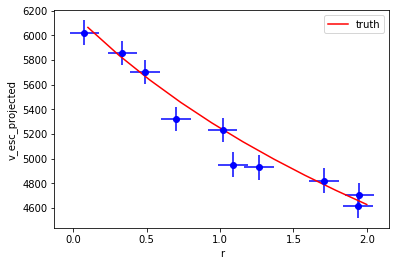

In [76]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.2, name = 'FlatLambdaCDM')
cosmo_params = cosmology(cosmo)

z = 0.2
radial_bins = 10
y_err = 100
x_err = 0.10
N = 100

Omega_M = 0.2
little_h = 0.7

M200 = 1e16*u.solMass
M200,R200,conc,rho_s, sigma_rho_s,r_s, sigma_r_s =  nfws_errors(M200, 0.2, z,cosmo_params, cosmo.name)

radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
theta_data_array = radius_array / D_A(z, cosmo_params, cosmo.name).value



r_truth, y_truth = v_esc_NFW_M200(theta_data_array,z,M200.value,N,cosmo_params, cosmo.name)
ydata = y_truth + np.random.normal(0,y_err,size=radial_bins) 
ydata_err = np.repeat(y_err, len(ydata))
xdata = r_truth + np.random.normal(0,x_err,size=radial_bins)
xdata_err = np.repeat(x_err, len(ydata))


plt.plot(r_truth, y_truth, "r", label = 'truth')
plt.errorbar(xdata, ydata, xerr = xdata_err, yerr=ydata_err, fmt = "bo")
plt.ylabel("v_esc_projected")
plt.xlabel("r")
plt.legend()
plt.show()

(100, 2000, 3)


C:\Users\nsuse\Anaconda3\envs\env_full\lib\site-packages\corner\corner.py:294: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, 1.1 * np.max(n))
C:\Users\nsuse\Anaconda3\envs\env_full\lib\site-packages\corner\corner.py:532: RuntimeWarning: invalid value encountered in true_divide
  sm /= sm[-1]
C:\Users\nsuse\Anaconda3\envs\env_full\lib\site-packages\corner\corner.py:536: RuntimeWarning: invalid value encountered in less_equal
  V[i] = Hflat[sm <= v0][-1]


KeyboardInterrupt: 

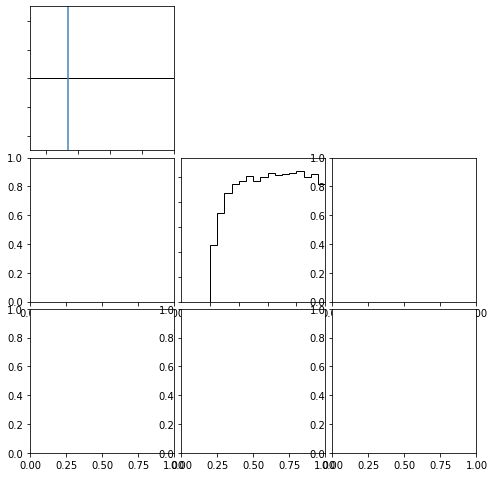

In [78]:
def lnprior(theta):
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    
    if not((1e13 < p_rho_s < 1e17) & (0.2 < p_r_s < 1) & (1e13 < p_M200 < 1e17)):
          return -np.inf
        
    return 0.0

def lnlike(theta, x, y, yerr, xerr): 
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    p_theta_array = x
    
    ymodel = v_esc_NFWs(p_theta_array,z,M200, p_rho_s, p_r_s,N,cosmo_params,'FlatLambdaCDM')

    inv_sigma2 = 1.0/((ydata_err**2) + (xdata_err**2))
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

def lnprob(theta, x, y, yerr, xerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr, xerr)
    
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    
    return lp + ll

ndim, nwalkers, nsteps = 3, 100, 2000
p0 = np.transpose([np.random.uniform(1,10000,size=nwalkers)*1e13, np.random.uniform(0.2,1,size=nwalkers),np.random.uniform(1,10000,size=nwalkers)*1e13])#print np.shape(p0)

# pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err, xdata_err))
sampler.run_mcmc(p0, nsteps)

burn = 500
samples = sampler.chain[:, burn:, :].reshape((-1, 3))
print (np.shape(sampler.chain))

fig = corner.corner(samples[:,:], labels=["rho_s", "r_s", "M200"], truths = [rho_s, r_s, M200.value], range=[(1e14,1e15), (0.0,1.0), (1e13,1e15)])
plt.show()

percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print (len(percentile_array))
rho_s_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
rho_s_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
rho_s_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
rho_s_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
r_s_fit =  np.percentile(sampler.chain[:,burn:,1],percentile_array)
r_s_fit_50 =  np.percentile(sampler.chain[:,burn:,1],50)
r_s_fit_33 =  np.percentile(sampler.chain[:,burn:,1],33-16.5)
r_s_fit_67 =  np.percentile(sampler.chain[:,burn:,1],67+16.5)
print ('median(rho_s) = ', rho_s_fit_50, '+/-', rho_s_fit_67-rho_s_fit_50, rho_s_fit_50-rho_s_fit_33)
print ('median(log rho_s) = ', np.log10(rho_s_fit_50), '+/-', np.log10(rho_s_fit_67)-np.log10(rho_s_fit_50), np.log10(rho_s_fit_50) -np.log10(rho_s_fit_33))
sigma_rho_s_fit = (rho_s_fit_67-rho_s_fit_50 + rho_s_fit_50-rho_s_fit_33)/2.0
print ('Truth: ', np.log10(rho_s))
print ('median(r_s) = ', r_s_fit_50, '+/-', r_s_fit_67-r_s_fit_50, r_s_fit_50-r_s_fit_33)
sigma_rho_s_fit = (r_s_fit_67-r_s_fit_50 + r_s_fit_50-r_s_fit_33)/2.0
print ('Truth: ',r_s)
M200_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
M200_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
M200_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
M200_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
print ('median(M200) = ', M200_fit_50, '+/-', M200_fit_67-M200_fit_50, M200_fit_50-M200_fit_33)
print ('median(logM200) = ', np.log10(M200_fit_50), '+/-', np.log10(M200_fit_67)-np.log10(M200_fit_50), np.log10(M200_fit_50) -np.log10(M200_fit_33))
sigma_M200_fit = (M200_fit_67-M200_fit_50 + M200_fit_50-M200_fit_33)/2.0
print ('Truth: ', np.log10(M200.value))